In [1]:
import numpy as np

import pandas as pd
import scipy.sparse
import pickle
import igraph
import h5py
import dask.dataframe as dd
import dask.array as da
from dask.diagnostics import ProgressBar

In [2]:
%cd ..

/home/kuba/Projects/github_search


## NOTE

Pairwise matrix should contain distances between nodes

In [3]:
call_graph_i = pickle.load(open("data/call_igraph.pkl", "rb"))

In [4]:
call_graph_i.vcount()

250891

## Graph distances

Because we have almost 200k nodes, running shortest paths algorithms would result in 200k x 200k matrix.
This is infeasible matrix if its dtype is float64 which is usually result of running such algorithms.

Because of this we need to run batched shortest paths algorithm. The result is then stored in *uint8* matrix, which is over 30GB, so a machine with 64GB RAM will be able to handle it.

In [5]:
import tqdm


def get_distance_matrix(igraph, batch_size, dtype="uint8"):
    n = igraph.vcount()
    dists = np.zeros((n, n), dtype=dtype)

    for i in tqdm.tqdm(range(0, n - batch_size, batch_size)):
        i_dists = igraph.shortest_paths(np.arange(i, i + batch_size))
        dists[i : i + batch_size] = np.array(i_dists).astype("uint8")
    dists[i:n] = np.array(igraph.shortest_paths(np.arange(i, n))).astype("uint8")
    return dists

In [10]:
dists = get_distance_matrix(call_graph_i, 100)

100%|██████████| 2508/2508 [2:35:07<00:00,  3.71s/it]  


In [11]:
n = dists.shape[0]

# HMDS

This is an algorithm proposed in [Representation Tradeoffs for Hyperbolic Embeddings](http://proceedings.mlr.press/v80/sala18a/sala18a.pdf).

It learns embeddings in hyperbolic spaces based on pairwise distance matrix $D$.

The algorithm learns embedding in $d$-dimensional hyperbolic space by putting

$Y_{i,j} = - cosh(D_{i,j})$ 

and then running PCA on $Y$.

f = h5py.File("data/call_graph_dists.h5", 'w')
dset = f.create_dataset("dists", (n, n), dtype='uint8', data=dists)
f.close()

In [6]:
f = h5py.File("data/call_graph_dists.h5", "r")

In [7]:
dset = f["dists"]

In [8]:
%%time
dists_dd = dd.from_array(dset, chunksize=5000)

CPU times: user 8.01 s, sys: 159 ms, total: 8.17 s
Wall time: 8.17 s


In [9]:
%%time
hcos_dists_dd = dists_dd.map_partitions(lambda x: -np.cosh(x).astype("float32"))

CPU times: user 13.1 s, sys: 106 ms, total: 13.3 s
Wall time: 13.3 s


In [10]:
from dask_ml.decomposition import PCA as DaskPCA
from dask_ml.decomposition import IncrementalPCA as DaskIncrementalPCA
from dask_ml.decomposition import TruncatedSVD as DaskTruncatedSVD

ipca = DaskIncrementalPCA(n_components=100, svd_solver="randomized")

In [11]:
hcos_dists_dd.to_dask_array()

dask.array<values, shape=(nan, 250891), dtype=float32, chunksize=(nan, 250891), chunktype=numpy.ndarray>

In [58]:
import tqdm
import pickle

In [59]:
for i in tqdm.tqdm(range(hcos_dists_dd.npartitions)):
    ipca.partial_fit(
        hcos_dists_dd.get_partition(i).to_dask_array(lengths=True).astype("float32")
    )

  0%|          | 0/51 [00:00<?, ?it/s]/home/kuba/.local/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
100%|██████████| 51/51 [1:21:02<00:00, 95.35s/it]


In [60]:
pickle.dump(ipca, open("data/ipca.pkl", "wb"))

In [12]:
ipca = pickle.load(open("data/ipca.pkl", "rb"))

In [13]:
ipca.components_ = ipca.components_.astype("float32")
ipca.mean_ = ipca.mean_.astype("float32")

In [14]:
res_da = hcos_dists_dd.map_partitions(
    lambda X: pd.DataFrame(
        ((np.array(X) - ipca.mean_) @ ipca.components_.T).astype("float16")
    )
)

In [15]:
import tqdm

hmds_features = pd.DataFrame([])

for i in tqdm.tqdm(range(res_da.npartitions)):
    hmds_features_partition = res_da.get_partition(i).compute()
    hmds_features = pd.concat([hmds_features, hmds_features_partition])

100%|██████████| 51/51 [18:18<00:00, 21.54s/it]


In [17]:
hmds_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250891 entries, 0 to 890
Data columns (total 100 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       250891 non-null  float16
 1   1       250891 non-null  float16
 2   2       250891 non-null  float16
 3   3       250891 non-null  float16
 4   4       250891 non-null  float16
 5   5       250891 non-null  float16
 6   6       250891 non-null  float16
 7   7       250891 non-null  float16
 8   8       250891 non-null  float16
 9   9       250891 non-null  float16
 10  10      250891 non-null  float16
 11  11      250891 non-null  float16
 12  12      250891 non-null  float16
 13  13      250891 non-null  float16
 14  14      250891 non-null  float16
 15  15      250891 non-null  float16
 16  16      250891 non-null  float16
 17  17      250891 non-null  float16
 18  18      250891 non-null  float16
 19  19      250891 non-null  float16
 20  20      250891 non-null  float16
 21  21      2508

In [18]:
hmds_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,250891.0,250891.00000,250891.00,250891.000000,250891.0000,250891.00,250891.00000,250891.000000,250891.0,250891.00,...,250891.000000,250891.000000,250891.0000,250891.00000,250891.000000,250891.000000,250891.000000,250891.000000,250891.000000,250891.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.000000,0.0000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-inf,-42976.00000,-31568.00,-47552.000000,-22368.0000,-17280.00,-15344.00000,-15024.000000,-26560.0,-10840.00,...,-4704.000000,-3530.000000,-2616.0000,-2338.00000,-3772.000000,-2340.000000,-2982.000000,-2398.000000,-3774.000000,-2662.000000
25%,-4560.0,-1637.00000,-1026.00,-629.500000,-844.0000,-803.25,-566.50000,-508.500000,-608.5,-410.25,...,-87.250000,-82.375000,-83.6250,-87.81250,-82.812500,-76.187500,-83.812500,-78.625000,-79.312500,-74.062500
50%,2696.0,-45.15625,387.75,31.609375,86.4375,-184.75,-10.78125,-14.398438,14.0,41.75,...,-3.693359,1.512695,-4.1250,-0.95459,-4.726562,-7.289062,-7.140625,-1.901367,-2.769531,1.461914
75%,6836.0,2374.00000,1272.00,742.500000,728.5000,730.50,577.00000,541.500000,611.5,431.00,...,92.375000,92.937500,85.0625,80.50000,84.625000,78.437500,86.625000,75.750000,86.750000,74.500000
max,13416.0,21584.00000,21344.00,11864.000000,22848.0000,14640.00,16752.00000,13768.000000,16464.0,13392.00,...,2844.000000,3138.000000,2864.0000,3314.00000,2348.000000,2372.000000,3302.000000,2584.000000,3156.000000,3440.000000


In [19]:
hmds_features.to_csv("data/hmds_features100.csv")

In [36]:
hmds_features.describe()

,0,1,2,3,4,5,6,7,8,9
count,250891.000000,250891.000000,250891.000000,250891.000000,2.508910e+05,250891.000000,2.508910e+05,250891.000000,250891.000000,250891.000000
mean,-0.000026,-0.000070,0.000028,0.000017,-2.576524e-07,-0.000021,3.956584e-08,0.000001,0.000002,-0.000005
std,9329.581303,3940.710498,2393.783059,1608.515135,1.504860e+03,1410.122647,1.125335e+03,960.422103,995.168821,810.355107
min,-191658.800000,-42607.070000,-31738.125000,-40693.180000,-3.365417e+04,-15352.530000,-1.388721e+04,-21858.824000,-10934.708000,-21200.990000
25%,-4559.739000,-1633.363500,-1007.042900,-641.922455,-6.826794e+02,-833.286220,-5.735587e+02,-547.630050,-489.044740,-417.350620
50%,2697.698000,-52.367184,387.223700,9.842993,-3.395461e+01,-205.350980,-2.514593e+01,-6.040407,6.640071,-44.662320
75%,6833.989500,2392.623400,1241.718850,683.006530,6.048834e+02,725.444900,5.299798e+02,564.080400,484.843000,371.313645
max,13414.081000,21494.496000,21335.578000,15697.617000,2.377002e+04,13093.697000,1.824963e+04,20962.053000,14405.590000,12819.588000


<AxesSubplot:ylabel='Frequency'>

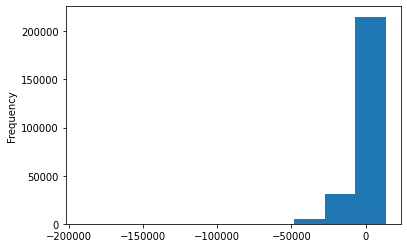

In [33]:
hmds_features.iloc[:, 0].plot.hist()

In [35]:
hmds_features.iloc[:, 0].describe()

count    250891.000000
mean         -0.000026
std        9329.581303
min     -191658.800000
25%       -4559.739000
50%        2697.698000
75%        6833.989500
max       13414.081000
Name: 0, dtype: float64

In [41]:
with ProgressBar():
    p1 = res_da.get_partition(0).compute()

[########################################] | 100% Completed |  1min 17.8s


<ipython-input-39-7295f8c2aeb9>:1: RuntimeWarning: overflow encountered in matmul
  res_da = hcos_dists_dd.map_partitions(lambda X: pd.DataFrame((np.array(X) - ipca.mean_) @ ipca.components_.T))


In [71]:
res_da.shape

(Delayed('int-d3ed17b3-5fb2-41ca-80cf-215c50d93da9'), 10)

In [70]:
with ProgressBar():
    res_da.to_hdf("data/hmds_features.h5", "/hmds")

[########                                ] | 20% Completed | 31.9s


KeyboardInterrupt: 

In [45]:
p1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5000 non-null   float16
 1   1       5000 non-null   float16
 2   2       5000 non-null   float16
 3   3       5000 non-null   float16
 4   4       5000 non-null   float16
 5   5       5000 non-null   float16
 6   6       5000 non-null   float16
 7   7       5000 non-null   float16
 8   8       5000 non-null   float16
 9   9       5000 non-null   float16
dtypes: float16(10)
memory usage: 97.8 KB


In [26]:
with ProgressBar():
    hp1 = hcos_dists_dd.get_partition(0).compute()

[########################################] | 100% Completed | 14.7s


In [36]:
np.array(hp1).shape

(5000, 250891)

(5000, 250891)

In [ ]:
p1.shape()

In [ ]:
res_da.to_hdf("data/")

In [ ]:
with ProgressBar():
    res = res_da.compute()

[####################                    ] | 50% Completed | 43.6s

In [ ]:
dask

In [27]:
hcos_dists_dd.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 250891 entries, 0 to 250890
dtypes: float16(250891)

In [22]:
(250891 ** 2) / 1000000000

62.946293881

In [ ]:
%%time
ipca.transform(hcos_dists_dd.to_dask_array(lengths=True))

In [ ]:
features = ipca.transform(hcos_dists_dd.to_dask_array(lengths=True))

In [ ]:
f.close()